<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#FuncNode" data-toc-modified-id="FuncNode-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FuncNode</a></span><ul class="toc-item"><li><span><a href="#What-for?" data-toc-modified-id="What-for?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What for?</a></span></li><li><span><a href="#What-can-FuncNode-do?" data-toc-modified-id="What-can-FuncNode-do?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What can <code>FuncNode</code> do?</a></span></li><li><span><a href="#What's-with-the-names?" data-toc-modified-id="What's-with-the-names?-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>What's with the names?</a></span></li></ul></li><li><span><a href="#A-DAG" data-toc-modified-id="A-DAG-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A DAG</a></span><ul class="toc-item"><li><span><a href="#Extending-an-existing-dag" data-toc-modified-id="Extending-an-existing-dag-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Extending an existing dag</a></span></li></ul></li><li><span><a href="#Example:-Evaluating-a-classifier" data-toc-modified-id="Example:-Evaluating-a-classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example: Evaluating a classifier</a></span><ul class="toc-item"><li><span><a href="#classifier_score" data-toc-modified-id="classifier_score-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>classifier_score</a></span></li><li><span><a href="#Making-it-more-useful" data-toc-modified-id="Making-it-more-useful-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Making it more useful</a></span></li><li><span><a href="#Making-the-DAG-bigger" data-toc-modified-id="Making-the-DAG-bigger-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Making the DAG bigger</a></span></li><li><span><a href="#Getting-a-sub-dag" data-toc-modified-id="Getting-a-sub-dag-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Getting a sub-dag</a></span></li></ul></li><li><span><a href="#Scrap" data-toc-modified-id="Scrap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scrap</a></span></li><li><span><a href="#Miscellaneous" data-toc-modified-id="Miscellaneous-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Miscellaneous</a></span><ul class="toc-item"><li><span><a href="#iterize-DAGs" data-toc-modified-id="iterize-DAGs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>iterize DAGs</a></span></li></ul></li></ul></div>

# Intro

As a matter of introduction, we'll show you how `DAG` composes a set of functions,
connecting them (by default) via their argument and function names,
resulting in another function.

There's a lot more control to making `DAG`s, a lot more to a `DAG`s than just making 
a function, and a lot more to meshed than just making `DAG`s. 
But let's keep it simple at first.

In [17]:
from meshed import DAG

def this(a, b=1):
    return a + b
def that(x, b=1):
    return x * b
def combine(this, that):
    return (this, that)

dag = DAG((this, that, combine))
print(dag.synopsis_string())

a,b -> this_ -> this
x,b -> that_ -> that
this,that -> combine_ -> combine


But what does it do?

It's a callable, with a signature:

In [18]:
from inspect import signature
signature(dag)

<Sig (a, x, b=1)>

And when you call it, it executes the dag from the root values you give it and
returns the leaf output values.

In [23]:
dag(2, 1, 3)  # dag(a=2, x=1, b=3) == dag((a+b,x*b) == (2+3,1*3) == (5, 3)

(5, 3)

In [22]:
dag(2, 1)  # dag(a=2, x=1) == dag(a=2, x=1, b=1) == (a+b,x*b) == (2+1,1*1) == (3, 1)

(3, 1)

You can see (and save image, or ascii art) the dag:

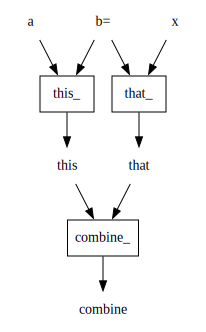

In [24]:
dag.dot_digraph()

You also have a some amount of control over this view (see https://graphviz.org/ for more)

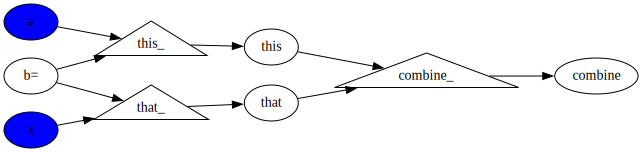

In [43]:
dag.dot_digraph(
    start_lines="rankdir=LR", 
    end_lines='a, x [style=filled fillcolor=blue]', 
    vnode_shape='ellipse', 
    fnode_shape='triangle'
)

You can extend a dag

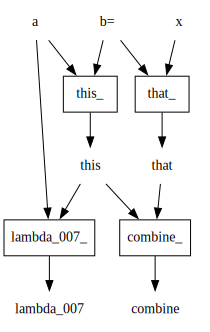

In [47]:
dag2 = DAG([*dag, lambda this, a: this + a])  # Note that [*dag] is a list of func nodes
# dag2 = dag + (lambda this, a: this + a)  # equivalently (adding dags, and functions)
dag2.dot_digraph()

You can get a sub-dag by specifying desired input(s) and outputs.

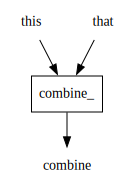

In [16]:
dag2['that this':'combine'].dot_digraph()  # or dag2[['that', 'this']:'combine'].dot_digraph()

# FuncNode

The `FuncNode` class is a cornerstone class of `meshed`. 

It wraps a function with information on how to interact with its environment. 

Or more precisely, where, in a scope (where variables/data is recorded), it sources its inputs and writes its results.

In [9]:
from meshed import FuncNode

## What for?

Say you have a function to multiply numbers

In [10]:
def multiply(x, y):
    return x * y

And you use it in some code like this:

In [11]:
item_price = 3.5
num_of_items = 2
total_price = multiply(item_price, num_of_items)

What the execution of `total_price = multiply(item_price, num_of_items)` does is
- grab the values (in the locals scope -- a dict), of ``item_price`` and ``num_of_items``,
- call the multiply function on these, and then
- write the result to a variable (in locals) named ``total_price``

`FuncNode` is a function wrapper that specification of such a `output = function(...inputs...)` assignment statement 
in such a way that it can carry it out on a `scope`. A `scope` is a `dict` where the function can find it's input values and write it's output values 
(if the user so chooses). 

For example, the `FuncNode` form of the above statement would be:

In [12]:
func_node = FuncNode(
    func=multiply, 
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
)
func_node

FuncNode(item_price,num_of_items -> multiply_ -> multiply)

Note the `bind` is a mapping **from** the variable names of the wrapped function **to** the names of the scope.

That is, when it's time to execute, it tells the `FuncNode` where to find the values of its inputs. 

If an input is not specified in this `bind` mapping, the scope (external) name is supposed to be the same as the function's (internal) name.

## What can `FuncNode` do?

The purpose of a `FuncNode` is to source some inputs somewhere, compute something
with these, and write the result somewhere. That somewhere is what we call a
scope. 

A scope is a dictionary (or any mutuable mapping to be precise) and it works
like this:

In [13]:
scope = {'item_price': 3.5, 'num_of_items': 2}
func_node(scope)  # returns 7.0

7.0

In [14]:
scope  # and 7.0 was written in the scope

{'item_price': 3.5, 'num_of_items': 2, 'multiply': 7.0}

## What's with the names?

Consider ``item_price,num_of_items -> multiply_ -> multiply``.

See that the name of the function is used for the name of its output,
and an underscore-suffixed name for its function name.

That's the default behavior if you don't specify either a name (of the function)
for the `FuncNode`, or a `output_name`.

The underscore is to distinguish from the name of the function itself.

The function gets the underscore because this favors particular naming style. 

The

```
item_price,num_of_items -> multiply_ -> total_price
```

shows you what the `FuncNode` node looks like on the outside. Note the `multiply_` with the underscore. 
That's the default name the `FuncNode` gave to the function. The underscore is to distinguish from the name of the function itself. 

You can give it a custom name as well:

In [15]:
FuncNode(
    func=multiply, 
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
    out='daily_expense'
)

FuncNode(item_price,num_of_items -> multiply -> daily_expense)

In [16]:
FuncNode(
    func=multiply, 
    name='total_price',
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
)

FuncNode(item_price,num_of_items -> total_price -> _total_price)

In [17]:
FuncNode(
    func=multiply, 
    name='total_price',
    bind={'x': 'item_price', 'y': 'num_of_items'}, 
    out='daily_expense'
)

FuncNode(item_price,num_of_items -> total_price -> daily_expense)

Note: In the context of networks if you want to reuse a same function (say, `multiply`) in multiple places 
you'll **need** to give it a custom name because the functions are identified by this name in the network. 

Note: These default name rules are determined by (and therefore can be changed through) the `names_maker` argument of `FuncNode`.

# A DAG

A DAG (Direct Acyclic Graph) is determined by a bunch of `FuncNode`s. 

The `FuncNode`s alone determine what computations can take place and how these computation units interact with each other, 
and even what names are used by the interface of the DAG.

Therefore you can control all those aspects by specifying what you want in the `FuncNode`s. 

In [18]:
def add(x, y):
    return x * y

def mul(x, y):
    return x * y

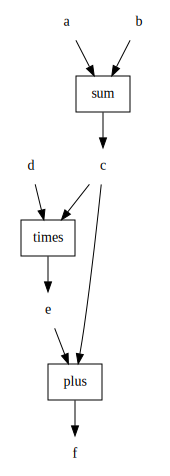

In [19]:
from meshed import DAG, FuncNode

dag = DAG(
    [
        FuncNode(add, 'sum',   {'x': 'a', 'y': 'b'}, 'c'),
        FuncNode(mul, 'times', {'x': 'c', 'y': 'd'}, 'e'),
        FuncNode(add, 'plus',  {'x': 'c', 'y': 'e'}, 'f'),
    ]
)
dag.dot_digraph()

In [20]:
dag(a=1, b=2, d=3)  # ((a + b) * d) + (a + b) = ((1 + 2) * 3) + (1 + 2) = 12

12

Note two things in the example above.

We reused `add` twice, but gave it a different name both times.

The functions all had the same input names (`x` and `y`), 
but these were mapped to other names which determined the dag's argument names (`a`, `b` and `d`) 
and computational flow (the `c` routing the output of `sum` to `times` and `plus`).

But as long as there are no name conflicts, there's a same bag of functions will result in the same unique `DAG`.

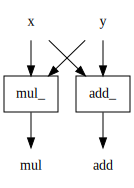

In [21]:
DAG([add, mul]).dot_digraph()

## Extending an existing dag

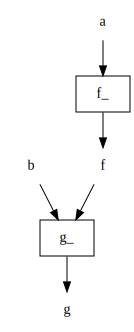

In [22]:
def f(a): return a * 2
def g(f, b): return f + b
    
dag = DAG([f, g])
dag.dot_digraph()

In [23]:
assert dag(2, 3) == 7
dag(a=2, b=3)  # a * 2 + b = 2 * 2 + 3 = 7

7

In [24]:
def h(a, b, g): return f"{a=} {b=} {g=}"
extended_dag = DAG([*dag, h])
assert extended_dag(a=2, b=3) == 'a=2 b=3 g=7'
extended_dag(a=2, b=3)

'a=2 b=3 g=7'

# Example: Evaluating a classifier

We'd like to develop some tools that will help a user to make a domain-specific metric (DSM) to evaluate binary classifiers.

Often, off-the-shelf metrics are used, such as accuracy, precision, recall, false-positive-rate, etc. 

The number these produce may not be directly interpretable in the domain they're being applied to. 

It can be helpful to see what false negative, false positive, etc. mean in the given context, 
and associate a value (penalty or reward) to these 
that reflects how much they contribute towards or contravene the actual objective of the classifier. 

If a COVID test turns out positive, what actions will be taken and what value do their consequences have depending on whether the positive test 
was true or false? Same question for true/false negative test results. Doing this valuation then allows us to produce a formula that
evaluates the worth of a test that has more meaning that flat false positive and false negative rates. 


##  classifier_score

In [25]:
def _aligned_items(a, b):
    """Yield (k, a_value, b_value) triples for all k that are both a key of a and of b"""
    # reason for casting to dict is to make sure things like pd.Series use the right keys.
    # could also use k in a.keys() etc. to solve this.
    a = dict(a)
    b = dict(b)
    for k in a:
        if k in b:
            yield k, a[k], b[k]
            
def dot_product(a, b):
    """
    >>> dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})
    5
    """
    return sum(ak * bk for _, ak, bk in _aligned_items(a, b))


def classifier_score(confusion_count, confusion_value):
    """Compute a score for a classifier that produced the `confusion_count`, based on the given `confusion_value`.
    Meant to be curried by fixing the confusion_value dict.
    
    The function is purposely general -- it is not specific to binary classifier outcomes, or even any classifier outcomes. 
    It simply computes a normalized dot product, depending on the inputs keys to align values to multiply and 
    considering a missing key as an expression of a null value. 
    """
    return dot_product(confusion_count, confusion_value) / sum(confusion_count.values())


In [26]:
dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})

5

In [27]:
# tp, fp, fn, tn shorthands for true positive, false positive, false nagative and true nagative
confusion_count = {'tp': 30, 'fp': 10, 'fn': 2, 'tn': 8}
confusion_value = {'tp': 0, 'fp': -1, 'fn': -5, 'tn': 0}

print(f"{dot_product(confusion_count, confusion_value)=}, {sum(confusion_count.values())=}")
classifier_score(confusion_count, confusion_value)

dot_product(confusion_count, confusion_value)=-20, sum(confusion_count.values())=50


-0.4

See how accuracy can be expressed by setting values of true positive and negative to 1, and zero for all errors:

In [28]:
confusion_value = {'tp': 1, 'fp': 0, 'fn': 0, 'tn': 1}  # this corresponds to the accuracy metric!
classifier_score(confusion_count, confusion_value)

0.76

## Making it more useful

To make it more readily usable, we should offer ways to easily get a `confusion_count` dict from various common situations. 

For example, how do we get these `confusion_count`? Possibly from an array of predictions and corresponding truths.

```
truth, prediction -> confusion_count
```

These predictions might come from an array `predict_prob` of scores that were thresholded to become a binary value that we call our prediction.

```
predict_proba, threshold -> prediction
```

And those `predict_proba` scores themselves might come from a trained model who is fed `test_X` inputs, the `test_y` array being this `truth` 
that we're talking about. 

```
model, test_X -> predict_proba
test_y -> truth
```

Providing the user with a few util tools 
to get from where they are (e.g. they have a model and some test data) 
to where they want to get to (e.g. getting a classifier_score)
is nice.

Making it clear on how to use these functions to get from A to B is also nice.
This can be done through documentation, examples, and (Uncle Bob style) through careful function and variable naming, as below.

In [29]:
from collections import Counter
import numpy as np


def confusion_count(prediction, truth):
    """Get a dict containing the counts of all combinations of predicction and corresponding truth values.

    >>> confusion_count(
    ... [0, 0, 1, 0, 1, 1, 1], 
    ... [0, 0, 0, 1, 1, 1, 1]
    ... )
    Counter({(0, 0): 2, (1, 0): 1, (0, 1): 1, (1, 1): 3})
    """
    return Counter(zip(prediction, truth))


def prediction(predict_proba, threshold):
    """Get an array of predictions from thresholding the scores of predict_proba array.

    >>> prediction([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], threshold=0.5)
    array([False, False,  True,  True,  True,  True])

    """
    return np.array(predict_proba) >= threshold


def predict_proba(model, test_X):
    """Get the prediction_proba scores of a model given some test data"""
    return model.predict_proba(test_X)

Conveniently, if we use names of functions and arguments as we did above, these can be used to indicate how they all relate to each other. 

That is to say, we need nothing further to make a DAG.

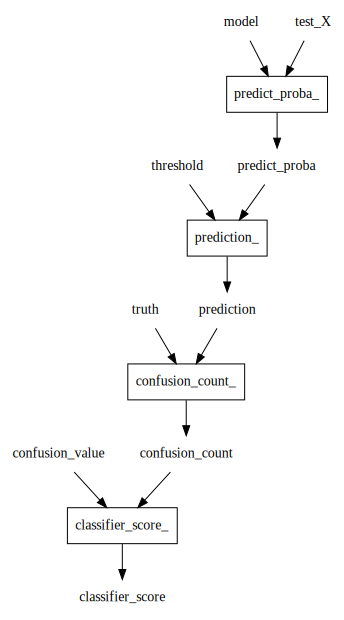

In [30]:
from meshed import DAG

dag = DAG([classifier_score, confusion_count, prediction, predict_proba])
dag.dot_digraph()

## Making the DAG bigger

And how did we get those top inputs (`model`, `test_X` and `test_y`)? 

Well, we trained a learner on some `train_X` and `train_y` that we get by splitting some `(X, y)` arrays...

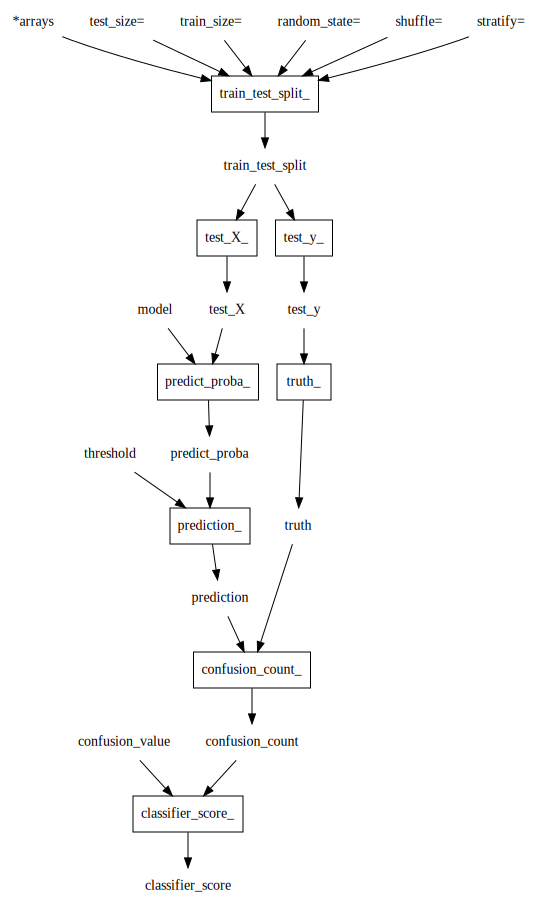

In [31]:
from sklearn.model_selection import train_test_split
from meshed import FuncNode, DAG
# from operator import itemgetter

# train_X, test_X, train_y, test_y = train_test_split(...)

def test_X(train_test_split):
    return train_test_split[1]

def test_y(train_test_split):
    return train_test_split[3]

def truth(test_y):  # to link up truth and test_y
    return test_y

# Note how we extend the existing dag by adding a few functions:
bigger_dag = DAG([*dag,  train_test_split, test_X, test_y, truth])
bigger_dag.dot_digraph()

## Getting a sub-dag

The current `bigger_dag` will get you `classifier_score` from input `model`, `threshold`, `confusion_value`, `arrays` and (optional) `options`. 

But what if you just wanted the `confusion_count`, and you already had the `predict_proba` and `truth` arrays?

Well, you can ask for `bigger_dag` to give you a sub-dag of your choice. We chose to use brackets `[...]` as the interface to get sub-dags, 
reminiscent of getting a sub-array of a numpy array or a sub-dataframe from a pandas dataframe.

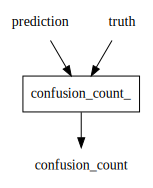

In [36]:
f = bigger_dag[['threshold', 'predict_proba'], 'confusion_count']  # repair
f = bigger_dag[['threshold', 'predict_proba', 'truth'], 'confusion_count']  # repair
f.dot_digraph()

Let's see what `bigger_dag[['threshold', 'predict_proba'], 'confusion_count']` means.

Here we're asking to get a function (a dag really) that will get us from `threshold` and `predict_proba` inputs to the value of `confusion_count`. 

But you'll notice that you get a function that has three arguments, not two:

In [37]:
from i2 import Sig  # i2 comes with meshed
Sig(f)

<Sig (prediction, truth)>

That's because `threshold` and `predict_proba` are not sufficient to get you the `confusion_count`.

What you actually get is smallest set of input arguments containing the ones you requested that will actually get you to the outputs you requested

So to get a sub-dag, you say `dag[input_args, output_args]`.

Both `input_args` and `output_args` can be 
- a single argument
- a list of arguments
- an empty slice (i.e. `:`), which means "no condition", i.e. "all possible" (inputs or outputs)

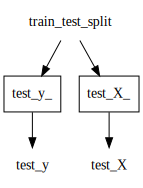

In [38]:
f = bigger_dag[:, ['test_X', 'test_y']]
f.dot_digraph()

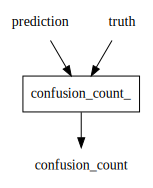

In [39]:
f = bigger_dag['prediction', :]
f.dot_digraph()

You can also specify your desired inputs and outputs as functions (if only used by a unique node) or func_node name. 

In [40]:
bigger_dag['prediction_', confusion_count].dot_digraph()

Make sure you understand the difference/equivalent between the above and the two following:

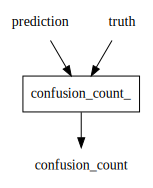

In [41]:
bigger_dag['prediction', confusion_count].dot_digraph()

In [42]:
bigger_dag[prediction, confusion_count].dot_digraph()  

Above we used `prediction`, the function -- not `'prediction'`, the string, which indicates the output of `prediction`.

If we wanted to specify the `prediction` function we a string, we should use the func_node name:  `'prediction_'`.

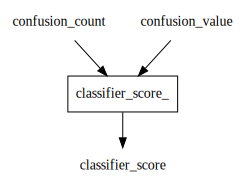

In [43]:
bigger_dag[:, 'classifier_score_'].dot_digraph()

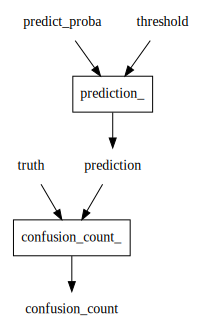

In [44]:
f = bigger_dag[['threshold', 'predict_proba', 'truth'], :]
f.dot_digraph()

# More examples

In [2]:
from functools import partial

import i2
from meshed import DAG
from meshed.util import objects_defined_in_module

non_underscored_callables = partial(
    objects_defined_in_module, 
    name_filt=lambda x: not x.startswith('_'),
    obj_filt=callable
)

## Vaccination and death

This dag models (simply!) the relationship between various vaccination variables such as
the `r` metric, `vax` (proportion of vaccinated people), `dealth_toll`, etc.

_Disclaimer: Both the relationships and the quantities involved here are sourced from my 
uninformed immagination and are not to be taken seriously, or as any indication of my 
actual beliefs about them._

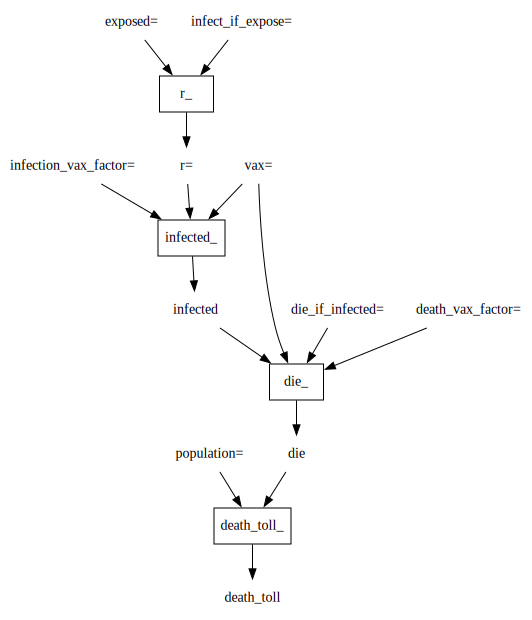

In [3]:
funcs = non_underscored_callables('meshed.examples.vaccine_vs_no_vaccine')

dag = DAG.from_funcs(funcs)
dag.dot_digraph()

## getting sub-DAGs conserves defaults

First, observe that when the functions you made a `DAG` with has arguments that had defaults, 
those defaults are conserved. 

Have a look at the `r` of the `infected` function for example"

In [4]:
i2.Sig(funcs['infected'])

<Sig (r: float = 1.2, vax: float = 0.5, infection_vax_factor: float = 0.15)>

If you call `dag`, this default will have no effect, since the input `r` of `infected` 
will then be determined by the output of the `r` function, itself determined by the 
`exposed` and `infect_if_expose` inputs. 

But the fact that the `FuncNode` of `infected` still has the original function with 
the original default is fortutious when you take sub-dags. For example, let's take the 
subdag that originates from `r` (the input of `infected`):

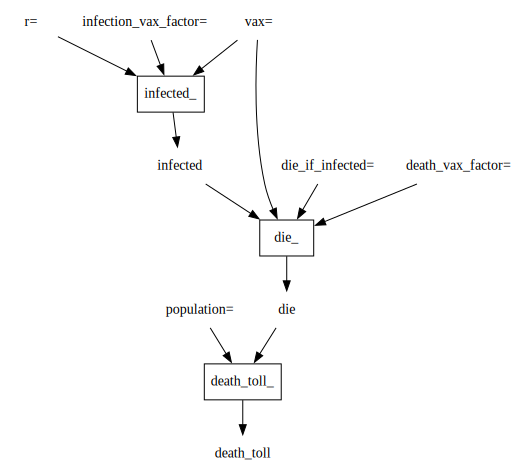

In [5]:
f = dag['r':]
f.dot_digraph()

Notice that the default of `r` is now used in the interface of the sub-dag:

In [6]:
i2.Sig(f)

<Sig (r: float = 1.2, vax: float = 0.5, infection_vax_factor: float = 0.15, die_if_infected: float = 0.05, death_vax_factor: float = 0.05, population: int = 1000000.0)>

## changing the defaults (`DAG.partial`)

In our particular example, all our arguments have defaults

In [7]:
i2.Sig(dag)

<Sig (exposed: float = 6, infect_if_expose: float = 0.2, vax: float = 0.5, infection_vax_factor: float = 0.15, die_if_infected: float = 0.05, death_vax_factor: float = 0.05, population: int = 1000000.0)>

So we can just call `dag` without arguments to see the result

In [8]:
dag()

18112

Let's see if we specify `vax=0.8` instead of using the default of `vax=0.5`.

In [9]:
dag(vax=0.8)

4608

Now, if we wanted to have a function that does what vax does, 
but with a default of `vax=0.8`, 
we would use `functools.partial` for this.

In [10]:
import functools

func_vax_80 = functools.partial(dag, vax=0.8)
func_vax_80()

4608

The shame about this though, is that `func_vax_80` is no longer a `DAG`. 
We can't visualize it, take sub-dags, etc. 

If you want to do `partial` on a `DAG`, staying in the `DAG` world, you need to use `DAG.partial`.

In [11]:
dag_vax_80 = dag.partial(vax=0.8) 
# dag_vax_80 = DAG.partial(dag, vax=0.8)  # equivalent alternative
dag_vax_80()

4608

## partializing intermediate var nodes?

But what if you wanted to change the default of `r`?

You can't just use `functools.partial` 
(or `DAG.partial`, which wants to stay aligned with the builtin)
(_TODO: Discuss. Should we extend `DAG.partial` to be able to change defaults of non-root var nodes?_)

In [13]:
# dag.partial(r=1.7)  # won't work! "TypeError: Got unexpected keyword arguments: r"

To do this, you'll need to bring `r` to the "surface", so it's a proper interface argument, 
change its default, and then put it back in its original context (dag):

In [14]:
def partialize_intermediate_nodes(dag, **name_and_default):
    """
    Partializes nodes in a dag that are not leaves, using the given default values.
    """
    # TODO: Could be made more efficient (maybe even O(1)), but probably not worth it
    for name, default in name_and_default.items():
        before_name_dag = dag[:name]
        after_name_dag = dag[name:]
        partialized_after_name_dag = after_name_dag.partial(**{name: default})
        dag = before_name_dag + partialized_after_name_dag
    return dag

dag_r_1_7 = partialize_intermediate_nodes(dag, r=1.7)

In [15]:
assert (
    dag_r_1_7['r':]() 
    == dag['r':](r=1.7)  # which is what the sub-dag with r=1.7 would give us
    == 25659  # namely
    != 18112  # which is not equal to this
    == dag['r':]()  # which is what the original sub-dag would give us if it used its default r
)

# Notice (and careful!) that dag_r_1_7 gives us the same result as dag though. 
# That's normal. Because in both, `r` is computed from the `r` function, not some default 
# `r` value (that's where they actually differ)
assert dag_r_1_7() == dag()

## Using a DAG to make other (parametrized) DAGs

We'll remind the reader that we use the `DAG` for more than just calling it, as a function. 

We can operate on both functions and datas the `DAG` is composed of, which enables many possibilities. 

Let's divide our vaccination DAG into two parts, cutting it at the `infected` node.

In [17]:
infected = dag[:'infected']
death_toll = dag['infected':]

The first part computes the `infected` value given `vax`, `infection_vax_factor`, `exposed` and `infect_if_expose`. 

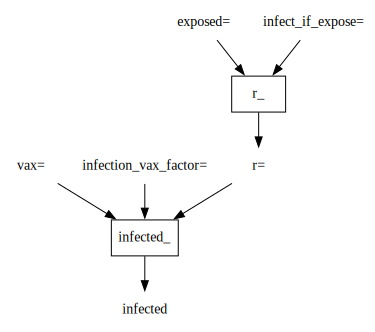

In [18]:
infected.dot_digraph()

The second part computes the `death_toll` given this `infected` value, along with other parameters 
(of which, `vax` again). 

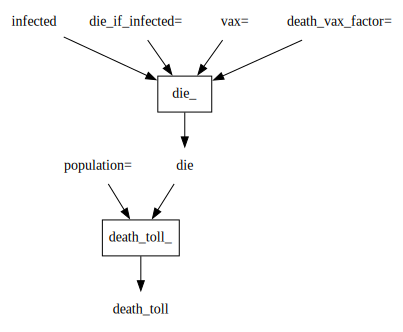

In [19]:
death_toll.dot_digraph()

Say you're in a situation where you wanted to compute the `infected` value using the first DAG,
then fix the `infected` input in the second DAG, and then use it to compute the `death_toll`, varying the other inputs. 

You could do this:

In [23]:
f = death_toll.partial(
    infected=infected(exposed=10, infect_if_expose=0.3, vax=0.7, infection_vax_factor=0.25),
    vax=0.7,  # CAREFUL!! Beed to be consistent with the value of vax that infected use
)
i2.Sig(f)

<Sig (infected: float = 1.425, die_if_infected: float = 0.05, vax: float = 0.5, death_vax_factor: float = 0.05, population: int = 1000000.0)>

If you wanted to enable others to use your vaccination model that way, you could make a function to do the above:

In [28]:
def mk_death_toll_model(exposed: float = 6, infect_if_expose: float = 0.2, vax: float = 0.5, infection_vax_factor: float = 0.15):
    return death_toll.partial(
        infected=infected(
            exposed=exposed, infect_if_expose=infect_if_expose, vax=vax, infection_vax_factor=infection_vax_factor
        ),
        vax=vax,
        _remove_bound_arguments=True  # because you might not want to see the bound arguments
    )

f = mk_death_toll_model()
i2.Sig(f)

<Sig (die_if_infected: float = 0.05, death_vax_factor: float = 0.05, population: int = 1000000.0)>

That's okay. But it takes some work to gather and copy over the types and default values of those 
arguments that are needed by infected, remembering to fix (and remove) those arguments that are shared 
(the case of `vax` here). 

Basically, a lot of boilerplate and error opportunities; for a pattern that in fact is quite useful.

That's why we made a tool for it this.

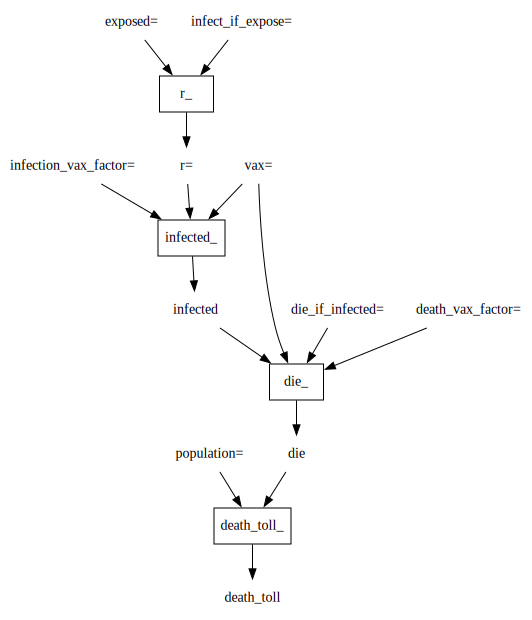

In [29]:
dag.dot_digraph()

(exposed: float = 6, infect_if_expose: float = 0.2, vax: float = 0.5, infection_vax_factor: float = 0.15)
(die_if_infected: float = 0.05, death_vax_factor: float = 0.05, population: int = 1000000.0)


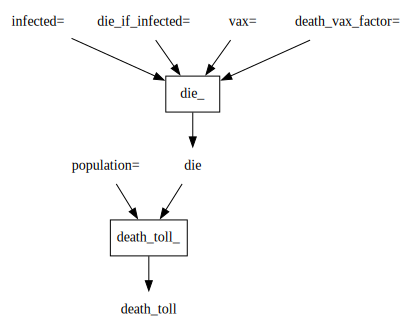

In [138]:
from meshed.dag import parametrized_dag_factory


dag_factory = parametrized_dag_factory(dag, 'infected')
print(f"{Sig(dag_factory)}")
f = dag_factory(exposed=10)
print(f"{Sig(f)}")
f.dot_digraph()


# Jsonizing mesh objects

In [202]:
from meshed import FuncNode, DAG
from meshed.makers import jdict_to_fnode, fnode_to_jdict, jdict_to_dag, dag_to_jdict

In [242]:
from py2json import obj_to_dotpath, dotpath_to_obj
from opus.mboxes import get_module_box
from meshed import DAG
from meshed.examples import funcs as meshed_examples_funcs

import itertools
all_funcs = list(itertools.chain.from_iterable(meshed_examples_funcs.values()))
# all_funcs.extend(get_module_box('opus.mboxes.wf_to_fvs').values())

all_funcs

dot_paths = list(map(obj_to_dotpath, all_funcs))
dag = DAG(all_funcs)

from functools import partial
from meshed.makers import jdict_to_fnode, fnode_to_jdict, jdict_to_dag, dag_to_jdict
from py2json import obj_to_dotpath, dotpath_to_obj

dag_encode = partial(dag_to_jdict, func_to_jdict=obj_to_dotpath)
dag_decode = partial(jdict_to_dag, jdict_to_func=dotpath_to_obj)

dag_decoded = dag_decode(dag_encode(dag))

In [250]:
from i2 import name_of_obj

key_of_obj = name_of_obj

store = {key_of_obj(func): func for func in all_funcs}



In [257]:
func_to_jdict_w_store = partial(dag_to_jdict, func_to_jdict=key_of_obj)
jdict_to_func_w_store = partial(jdict_to_dag, jdict_to_func=lambda func_name: store[func_name])

dag_encode = partial(dag_to_jdict, func_to_jdict=func_to_jdict_w_store)
dag_decode = partial(jdict_to_dag, jdict_to_func=jdict_to_func_w_store)

dag = DAG(all_funcs, name='my_dag')
# dag_decoded = dag_decode(dag_encode(dag))
dag_encode(dag)

AttributeError: 'function' object has no attribute 'name'

> /Users/thorwhalen/Dropbox/py/proj/i/meshed/meshed/makers.py(754)dag_to_jdict()
    752     fnode_to_jdict_ = partial(fnode_to_jdict, func_to_jdict=func_to_jdict)
    753     return {
--> 754         'name': dag.name,
    755         'func_nodes': list(map(fnode_to_jdict_, dag.func_nodes)),
    756     }



> /Users/thorwhalen/Dropbox/py/proj/i/meshed/meshed/makers.py(731)fnode_to_jdict()
    729     }
    730     if func_to_jdict is not None:
--> 731         jdict['func'] = func_to_jdict(fnode.func)
    732     return jdict
    733 

fnode = FuncNode(impressions,cost_per_impression -> cost_ -> cost)
func_to_jdict = functools.partial(<function dag_to_jdict at 0x29e1a6dd0>, func_to_jdict=<function name_of_obj at 0x1217b5a20>)


In [256]:
%pdb

Automatic pdb calling has been turned ON


DAG(func_nodes=[FuncNode(impressions,cost_per_impression -> cost_ -> cost), FuncNode(impressions,click_per_impression -> clicks_ -> clicks), FuncNode(clicks,sales_per_click -> sales_ -> sales)], name=None)

In [198]:
from types import ModuleType
isinstance(dotpath_to_obj('meshed.examples'), ModuleType)


module

In [199]:
t

['meshed.examples.online_marketing.cost',
 'meshed.examples.online_marketing.clicks',
 'meshed.examples.online_marketing.sales',
 'meshed.examples.online_marketing.revenue',
 'meshed.examples.online_marketing.profit',
 'meshed.examples.vaccine_vs_no_vaccine.r',
 'meshed.examples.vaccine_vs_no_vaccine.infected',
 'meshed.examples.vaccine_vs_no_vaccine.die',
 'meshed.examples.vaccine_vs_no_vaccine.death_toll',
 'meshed.examples.price_elasticity.profit',
 'meshed.examples.price_elasticity.revenue',
 'meshed.examples.price_elasticity.expense',
 'meshed.examples.price_elasticity.sold']

In [176]:
# fnode = FuncNode(
#     func=map, 
#     name='map', 
#     bind={'func': 0, 'iterable': 1},
#     out='transformed_iterable'
# )

In [ ]:
import ps

# Scrap

## DATA Epic: Upload and structure data

```python
from dol import Files

src_folder = 'some/source/folder'
src_store = Files(src_folder)

target_store = OtoSenseStore(...)  # user separated? permissions? 
target_store.save_this_shit(src_store)

# Example implementation:
# * Copies all values of src_store to {internal_key_eg_sha256: value, ...}
# * Write (src_filepath, internal_key_eg_sha256) in metadata place

# Or more explicit...
# target_store['my_special_place_for_this']
```

```
target_store = OtoSenseStore(
    secret_key=..., # taken from os.environ,
    access_key=..., # taken from os.environ,
    root_url=...,
    ..., 
    custom_metadata={
        'project_name': 'danfoss', 
        'description': 'blah blah',
        'use_case_description_file': 'tmp/sdf/dflk/',
    },
)
```


```
signal_store = {
    lkjdf897298398273984792793874: bytes...
}

signal_metadata_store = {
   lkjdf897298398273984792793874: src_key (root folder path), user
}
```

In [268]:
from dol import Files

s = Files('/Users/thorwhalen/Dropbox/py/proj/i/meshed/misc')

s['img_1.png']

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00n\x00\x00\x020\x08\x06\x00\x00\x00g@^U\x00\x00\x16\xa3IDATx^\xed\x9d\x07\x90\x14U\xd7\x86]\xe2\x02\x92\x11IU~"\x82\x08*\x82@\x11E\x05\x04\x04\x17\x91"g\x04\x04I\x92)\x94(\xa9H"A\x89R\x05\x08\xa2\xb0PdX\x82$\xc9a%JF\xc2\x12\x97\x1c\x84\xe5\xfcun\xd5\xf0\xc3\x9d\x8f\x91\xdf\xfdwf\xdf\xdb\xefSu\n\xbb\xefm\x17\xe6\xd9\xee\xe9\xe9\xb9\xe7\x9c\xe7\x84@\xf2\x9c\xbd\x83`@q\xa0P\x1c(\x14\x07\n\xc5\x81Bq\xa0P\x1c(\x14\x07\n\xc5\x81Bq\xa0P\x1c(\x14\x07\n\xc5\x81Bq\xa0P\x1c(\x14\x07\n\xc5\x81Bq\xa0@\x8b;z\xf4\xa8DEE\xc9\xae]\xbb$..\xce\x1ev\x1aHq*i\xf0\xe0\xc1R\xbati\x19>|\xb8T\xacXQ\x1a5j$\xf7\xee\xdd\xb3\xa7:\x0b\xa4\xb8S\xa7N\xc9s\xcf=\'\xad[\xb76\xdbK\x96,1\xdb\xbf\xff\xfe\xbb5\xd3] \xc5\xdd\xb9sGF\x8f\x1em.\x91\xe7\xcf\x9f\x97\xfe\xfd\xfbKXX\x98DFF\xdaS\x9d\x05R\x9c\xa2\xf2\x86\x0c\x19"M\x9a4\x91\x96-[J\xb2d\xc9d\xee\xdc\xb9\xf64g\x81\x14w\xf9\xf2e\xf3\xfe\xa6\xefm\xb1\xb1\xb1\xb2q\xe3FI\x9a4)\xc5%vf\xce\x9ci\xde\xd3\xe6\xcf\x9fo\xb6\x17-Zd.\x9

## parametrized_dag_factory

common_var_nodes={'a'}
common_var_node_values={'a': 'criss(x=1, y=2)'}


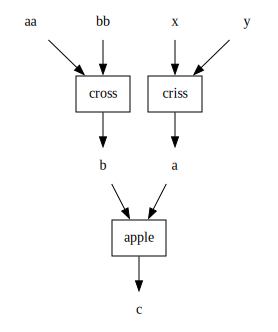

In [161]:
from meshed.base import *


def parametrized_dag_factory(dag: DAG, param_var_nodes: Union[str, Iterable[str]]):
    """
    Constructs a factory for sub-DAGs derived from the input DAG, with values of 
    specific 'parameter' variable nodes precomputed and fixed. These precomputed nodes, 
    and their ancestor nodes (unless required elsewhere), are omitted from the sub-DAG. 

    The factory function produced by this operation requires arguments corresponding to 
    the ancestor nodes of the parameter variable nodes. These arguments are used to 
    compute the values of the parameter nodes.

    This function reflects the typical structure of a class in object-oriented 
    programming, where initialization arguments are used to set certain fixed values 
    (attributes), which are then leveraged in subsequent methods. 

    >>> import i2
    >>> from meshed import code_to_dag
    >>> @code_to_dag
    ... def testdag():
    ...     a = criss(aa, aaa)
    ...     b = cross(aa, bb)
    ...     c = apple(a, b)
    ...     d = sauce(a, b)
    ...     e = applesauce(c, d)
    >>>
    >>> dag_factory = parametrized_dag_factory(testdag, 'a')
    >>> print(f"{i2.Sig(dag_factory)}")
    (aa, aaa)
    >>> d = dag_factory(aa=1, aaa=2)
    >>> print(f"{i2.Sig(d)}")
    (b)
    >>> d(b='bananna')
    'applesauce(c=apple(a=criss(aa=1, aaa=2), b=bananna), d=sauce(a=criss(aa=1, aaa=2), b=bananna))'

    """

    if isinstance(param_var_nodes, str):
        param_var_nodes = param_var_nodes.split()
    # The dag is split into two parts:
    #   Part whose role it is to compute the param_var_nodes from root nodes
    param_dag = dag[:param_var_nodes]
    #   Part that computes the rest based on these (and remaining root nodes)
    computation_dag = dag[param_var_nodes:]
    # Get the intersection of the two parts on the var nodes
    common_var_nodes = set(param_dag.var_nodes) & set(computation_dag.var_nodes)
    print(f"{common_var_nodes=}")

    @Sig(param_dag)
    def dag_factory(*parametrization_args, **parametrization_kwargs):
        # use the param_dag to compute the values of the parameter var nodes
        # (and what ever else happens to be in the leaves, but we'll remove that later)
        _ = param_dag(*parametrization_args, **parametrization_kwargs)
        # Get the values for all nodes that are common to param_dag and computation_dag
        # (There may be more than just param_var_nodes!)
        common_var_node_values = extract_dict(param_dag.last_scope, common_var_nodes)
        print(f"{common_var_node_values=}")
        # By fixing those values, you now have a the computation_dag you want
        # Note: Also, remove the bound arguments
        # (i.e. the arguments that were used to compute the values)
        # so that the user doesn't change those and get inconsistencies!
        d = computation_dag.partial(
            **common_var_node_values, _remove_bound_arguments=True
        )
        # Remember the var nodes that parametrized the dag
        # TODO: Is this a good idea? Meant for debugging really.
        d._common_var_node_values = common_var_node_values
        return d

    return dag_factory, param_dag, computation_dag


from meshed import code_to_dag

@code_to_dag
def dag1():
    a = criss(x,y)
    b = cross(aa, bb)
    c = apple(a, b)

dag_factory1, param_dag, computation_dag = parametrized_dag_factory(dag1, 'a')
assert str(Sig(dag_factory1)) == '(x, y)'

d = dag_factory1(x=1, y=2)
assert str(Sig(d)) == '(b)'  # but we DO NOT WANT THAT.
# assert str(Sig(d)) != '(aa, bb)'  # but we DO WANT THAT.
dag1.dot_digraph()


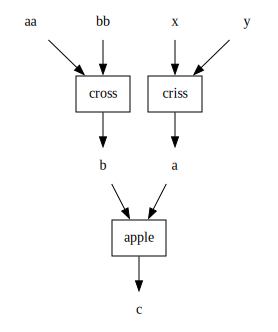

In [166]:
dag1.dot_digraph()

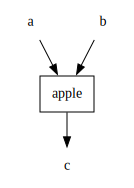

In [171]:
computation_dag = dag1['a':]
str(Sig(computation_dag)) == '(a, b)'
computation_dag.dot_digraph()


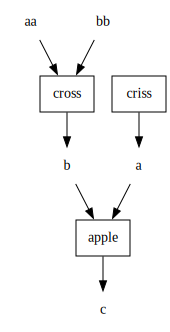

In [168]:
dag2.dot_digraph()

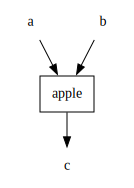

In [169]:
computation_dag = dag2['a':]
computation_dag.dot_digraph()

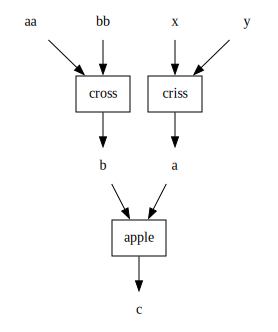

In [152]:
from meshed import code_to_dag
from meshed.dag import parametrized_dag_factory

@code_to_dag
def dag1():
    a = criss(x,y)
    b = cross(aa, bb)
    c = apple(a, b)


assert str(Sig(dag_factory1(x=1,y=2))) == '(b)'  # but we DO NOT WANT THAT.
assert str(Sig(dag_factory1(x=1,y=2))) != '(aa, bb)'  # but we DO WANT THAT.
dag1.dot_digraph()

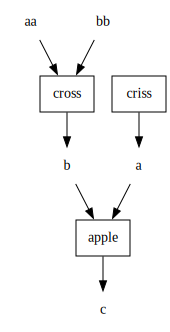

In [153]:
@code_to_dag
def dag2():
    a = criss()
    b = cross(aa, bb)
    c = apple(a, b)

dag_factory2 = parametrized_dag_factory(dag2, 'a')
assert str(Sig(dag_factory2())) == '(a, b)'
# <Sig (a, b)>  # to be consistent with the above, it should be Sig (b)
dag2.dot_digraph()

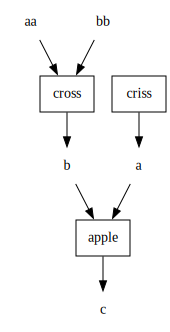

## graph operations

In [36]:
d = bigger_dag

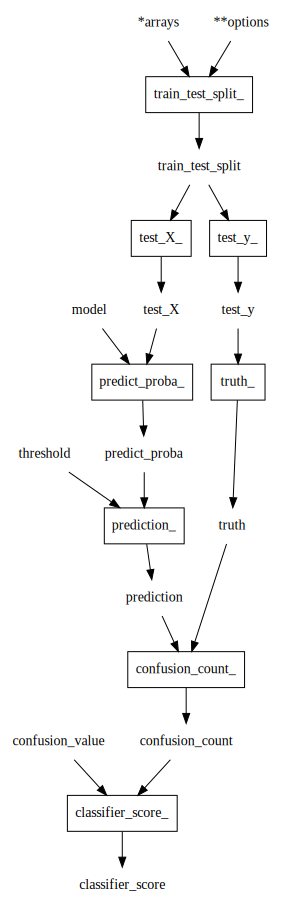

In [127]:
d.dot_digraph()

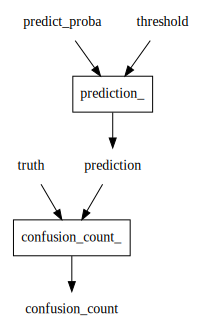

In [139]:
d[['threshold', 'predict_proba', 'truth'], :].dot_digraph()

In [43]:
dd = dag_from_funcnodes(d, ['threshold', 'predict_proba', 'truth'])
dd.dot_digraph()

In [41]:
extended_family(d.graph, ['prediction', 'truth'])

{FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 'confusion_count',
 'prediction',
 'truth'}

In [47]:
g = d.graph

In [59]:
from functools import partial
is_func_node = lambda x: isinstance(x, FuncNode)
t = list(filter(is_func_node, descendants(g, ['train_test_split'])))
t

[FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(train_test_split -> test_y_ -> test_y),
 FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 FuncNode(test_y -> truth_ -> truth),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba)]

In [60]:
tt = list(filter(is_func_node, ancestors(g, ['prediction'])))
tt

[FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(arrays,options -> train_test_split_ -> train_test_split),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba)]

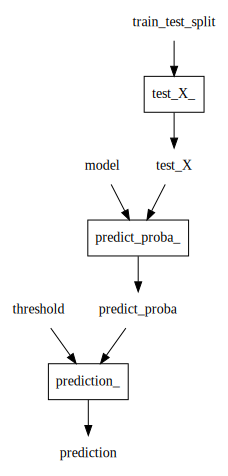

In [64]:
DAG(set(t).intersection(tt)).dot_digraph()

In [81]:
list(d)

[FuncNode(arrays,options -> train_test_split_ -> train_test_split),
 FuncNode(train_test_split -> test_y_ -> test_y),
 FuncNode(test_y -> truth_ -> truth),
 FuncNode(train_test_split -> test_X_ -> test_X),
 FuncNode(model,test_X -> predict_proba_ -> predict_proba),
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 FuncNode(prediction,truth -> confusion_count_ -> confusion_count),
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score)]

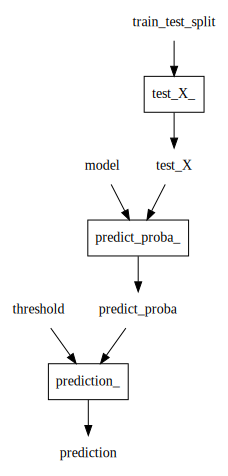

In [70]:
dd = d['train_test_split', 'prediction']
dd.dot_digraph()

In [72]:
Sig(dd)

<Sig (train_test_split, model, threshold)>

In [84]:
[x.name for x in d]

['train_test_split_',
 'test_y_',
 'truth_',
 'test_X_',
 'predict_proba_',
 'prediction_',
 'confusion_count_',
 'classifier_score_']

In [85]:
FuncNode(lambda x, y: x + y)

FuncNode(x,y -> <lambda>_ -> <lambda>)

# Miscellaneous

## iterize DAGs

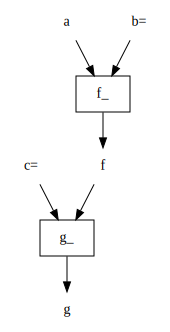

In [77]:
def f(a, b=2):
    return a + b

def g(f, c=3):
    return f * c

from meshed import DAG

d = DAG([f, g])

d.dot_digraph()

In [86]:
# if you needed to apply d to an iterator, you'd normally do this
list(map(d, [1, 2, 3]))

[9, 12, 15]

In [99]:
# But if you need a function that "looks like" d, but is "vectorized" (really iterized) version...
from lined import iterize
from i2 import Sig

di = iterize(d)
# di has the same signature as d:
Sig(di)

<Sig (a, b=2, c=3)>

In [87]:
# But works with a being an iterator
list(di([1,2,3]))

[9, 12, 15]

In [89]:
# Note that di will return an iterator that needs to be "consumed" (here with list)
# That is, no matter what the (iterable) type of the input is.
# You could use lined.Line

from lined import Line
di_list = Line(di, list)
di_list([1, 2, 3])

[9, 12, 15]

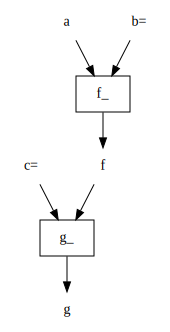

In [22]:
from lined import Line
from meshed import DAG

class DDag(DAG):
    wrappers = ()
    
    def __call__(self, *args, **kwargs):
        if not self.wrappers:
            return super().__call__(*args, **kwargs)
        else:
            decorator = Line(*self.wrappers)
            decorated_dag_call = decorator(super().__call__)
            return decorated_dag_call(*args, **kwargs)
        
        
def f(a, b=2):
    return a + b

def g(f, c=3):
    return f * c


# d = DDag([f, g])
d = DDag([f, g])

d.dot_digraph()

In [23]:
assert d(1,2,3) == 9  # can call
from i2 import Sig
assert str(Sig(d)) == '(a, b=2, c=3)'  # has correct signature

In [26]:
def dec(func):
    def _dec(*args, **kwargs):
        print(func.__name__, args, kwargs)
        return func(*args, **kwargs)
    return _dec

d.wrappers = (dec,)

In [30]:
def rev(func):
    def _rev(*args, **kwargs):
        assert not kwargs, "Can't have keyword arguments with rev"
        return func(*args[::-1])

    return _rev

d.wrappers = (dec, rev)
d(1, 2, 3)


__call__ (3, 2, 1) {}


5

In [35]:
from meshed.scrap.wrapping_dags import test_ddag

test_ddag()

_call (1, 2, 3) {}
_call (1, 2) {'c': 3}
_call (3, 2, 1) {}
